In [1]:
from rocketpy import Environment, Rocket, Flight, Fluid, LiquidMotor, CylindricalTank, MassFlowRateBasedTank
import datetime
from math import exp


Gravity Details

Acceleration of gravity at surface level:    9.7970 m/s²
Acceleration of gravity at  79.062 km (ASL): 9.5581 m/s²


Launch Site Details

Launch Date: 2025-11-11 12:00:00 UTC
Launch Site Latitude: 35.34700°
Launch Site Longitude: 117.80800°
Reference Datum: SIRGAS2000
Launch Site UTM coordinates: 573419.53 E    3911824.66 N
Launch Site UTM zone: 50S
Launch Site Surface Elevation: 217.0 m


Atmospheric Model Details

Atmospheric Model Type: Forecast
Forecast Maximum Height: 79.062 km
Forecast Time Period: from 2025-11-10 12:00:00 to 2025-11-26 12:00:00 utc
Forecast Hour Interval: 3 hrs
Forecast Latitude Range: From -90.0° to 90.0°
Forecast Longitude Range: From 0.0° to 359.75°

Surface Atmospheric Conditions

Surface Wind Speed: 1.10 m/s
Surface Wind Direction: 154.09°
Surface Wind Heading: 334.09°
Surface Pressure: 998.34 hPa
Surface Temperature: 286.08 K
Surface Air Density: 1.216 kg/m³
Surface Speed of Sound: 339.07 m/s


Earth Model Details

Earth Radius at Launch s

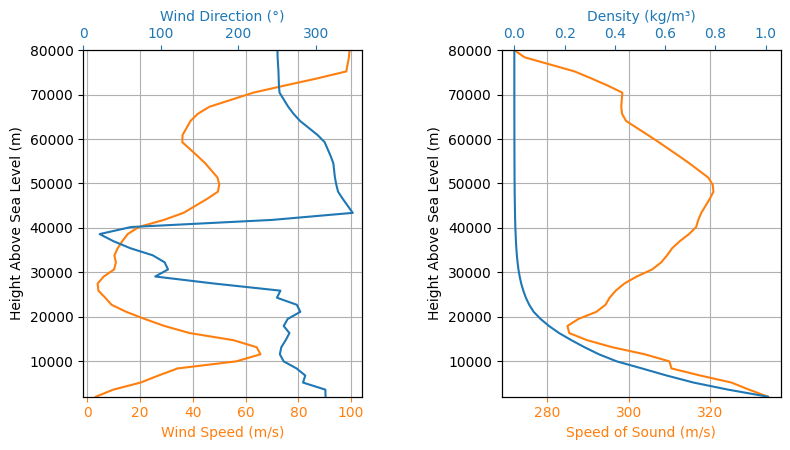

In [ ]:
# Environment definition
#date = datetime(2026, 5, 23, 18) Actual launch date
tomorrow = datetime.date.today() + datetime.timedelta(days=1)
env = Environment(latitude=35.347, longitude=117.808, elevation=2000) #approximate FAR location
env.set_date (
    (tomorrow.year, tomorrow.month, tomorrow.day, 12)
)
env.set_atmospheric_model(type="Forecast", file="GFS")
env.info()

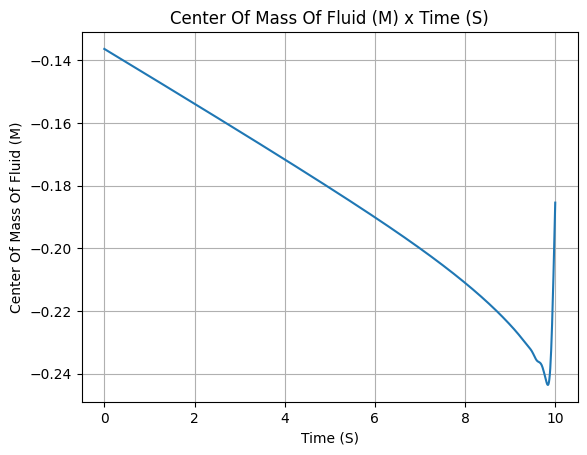

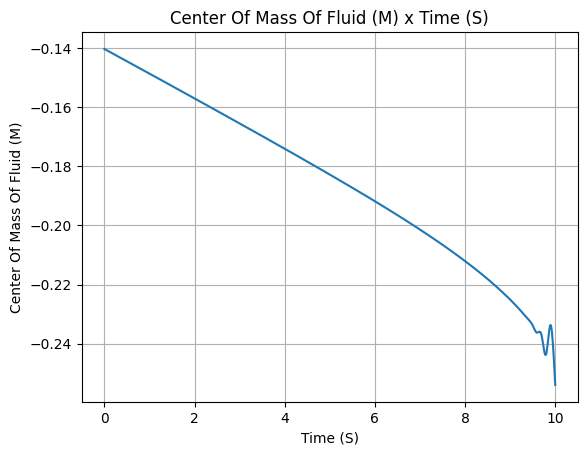

In [3]:
# Define fluids
oxidizer_liq = Fluid(name="LOX", density=1096.9997917)
oxidizer_gas = Fluid(name="GOX", density=4.3871) #literally no clue how accurate this is got it from here tho: https://webbook.nist.gov/cgi/fluid.cgi?T=90&PLow=&PHigh=3.0677043723391&PInc=&Digits=5&ID=C7782447&Action=Load&Type=IsoTherm&TUnit=K&PUnit=MPa&DUnit=kg%2Fm3&HUnit=kJ%2Fmol&WUnit=m%2Fs&VisUnit=uPa*s&STUnit=N%2Fm&RefState=DEF
fuel_liq = Fluid(name="kerosene_l", density=819.99862279)
fuel_gas = Fluid(name="kerosene_g", density=798.71) #check value, idk if its even needed tho
pressurant = Fluid(name="N2", density=35.092168658)

# Define tanks geometry
lox_shape = CylindricalTank(radius = 0.1016, height = 0.508, spherical_caps = True) #from bs early november 2025 openrocket
kero_shape = CylindricalTank(radius = 0.1016, height = 0.508, spherical_caps = True) #from bs early november 2025 openrocket
n2_shape = CylindricalTank(radius = 0.1016, height = 0.584, spherical_caps = True) #from bs early november 2025 openrocket

# Define tanks
oxidizer_tank = MassFlowRateBasedTank(
    name="oxidizer tank",
    geometry=lox_shape,
    flux_time=10,
    initial_liquid_mass= 6.082376233039845,
    initial_gas_mass=0, #not real, just makes life easier
    liquid_mass_flow_rate_in=0,
    liquid_mass_flow_rate_out=0.6082376233039845 * 0.999,
    gas_mass_flow_rate_in=0,
    gas_mass_flow_rate_out=0,
    liquid=oxidizer_liq,
    gas=oxidizer_gas,
)

fuel_tank = MassFlowRateBasedTank(
    name="fuel tank",
    geometry=kero_shape,
    flux_time=10,
    initial_liquid_mass= 4.344554453005255,
    initial_gas_mass=0, #not real, just makes life easier (altho maybe more real than 0 GOX)
    liquid_mass_flow_rate_in=0,
    liquid_mass_flow_rate_out=0.4344554453005255 * 0.999,
    gas_mass_flow_rate_in=0,
    gas_mass_flow_rate_out=0,
    liquid=fuel_liq,
    gas=fuel_gas,
)

pressurant_tank = MassFlowRateBasedTank(
    name="Pressurant Tank",
    geometry=n2_shape,
    flux_time=10,
    initial_liquid_mass=0,
    initial_gas_mass=.48, #6.640451661 is bs number from bs OR tank volume and PV = nRT at ~4500 psi and room temp but i can't use it because its overfilling the tank or some shit idk
    liquid_mass_flow_rate_in=0,
    liquid_mass_flow_rate_out=0,
    gas_mass_flow_rate_in=0,
    gas_mass_flow_rate_out= (.48/10)*0.999,
    gas=pressurant,
    liquid=pressurant,
)

# Evolution of the Tank center of mass position
oxidizer_tank.center_of_mass.plot()
fuel_tank.center_of_mass.plot()

Nozzle Details
Nozzle Radius: 0.03088 m

Motor Details
Total Burning Time: 10 s
Total Propellant Mass: 10.907 kg
Structural Mass Ratio: 0.000
Average Propellant Exhaust Velocity: 1913.359 m/s
Average Thrust: 2084.800 N
Maximum Thrust: 2214.39493755761 N at 9.965613 s after ignition.
Total Impulse: 20848.004 Ns



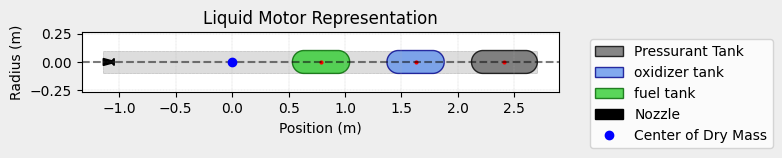

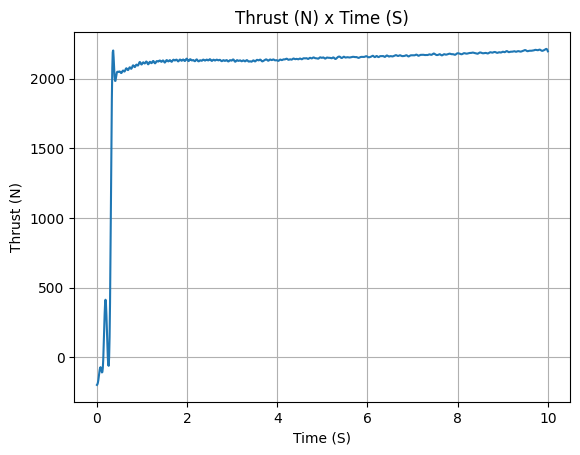

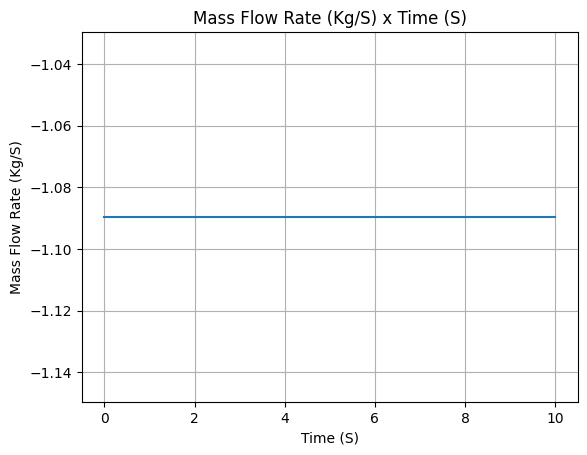

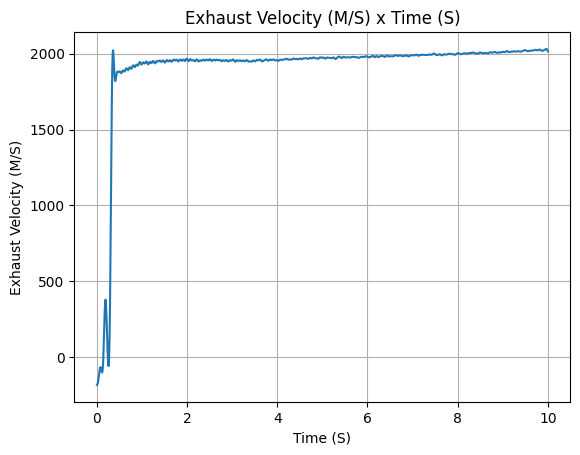

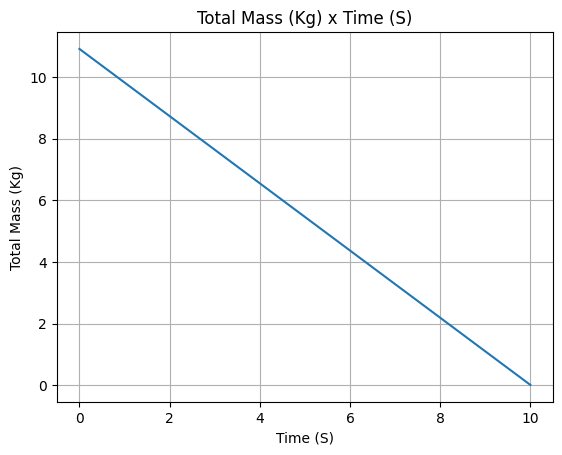

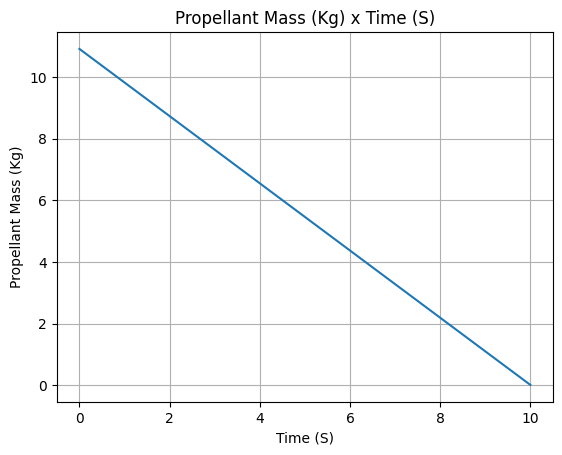

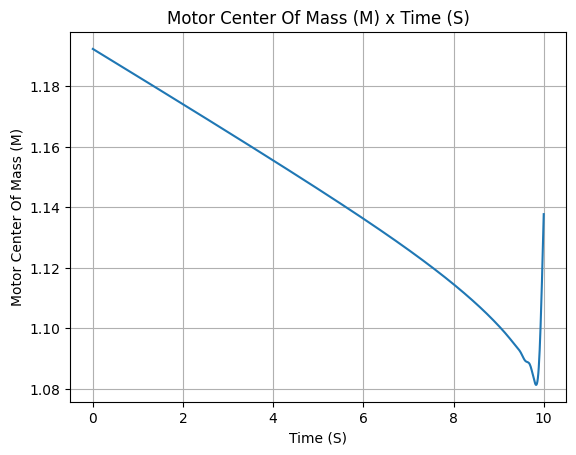

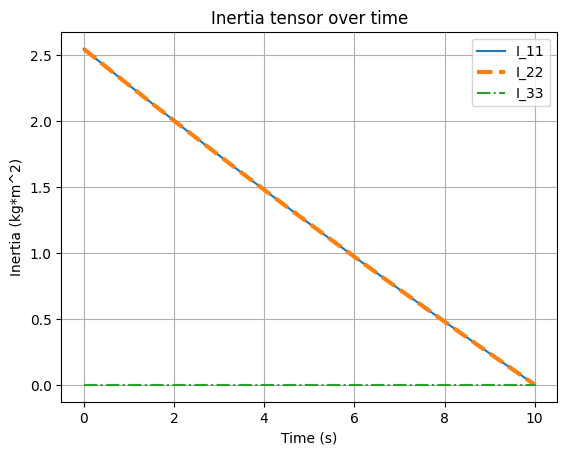

In [4]:
mu2c_yf = LiquidMotor(
    thrust_source="thrust_filtered_only.csv",
    center_of_dry_mass_position=0,
    dry_inertia=(0, 0, 0),
    dry_mass=0,
    burn_time=10,
    nozzle_radius=0.03088,
    nozzle_position=-1.143,
    coordinate_system_orientation="nozzle_to_combustion_chamber",
)

mu2c_yf.add_tank(pressurant_tank, position=2.413)
mu2c_yf.add_tank(oxidizer_tank, position=1.6256)
mu2c_yf.add_tank(fuel_tank, position=0.7874)

mu2c_yf.all_info()

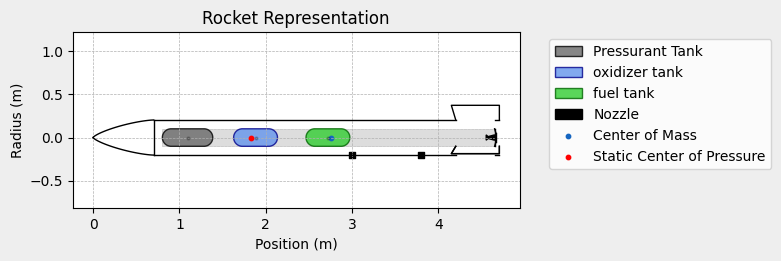

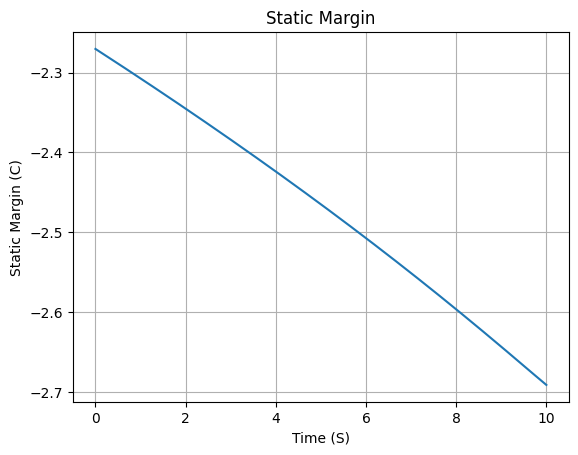

In [24]:
Fullscale_S = Rocket(
    radius=0.2032,
    mass=27.7258,
    inertia=(0,0,0),
    power_off_drag="drag_curve.csv",
    power_on_drag="drag_curve.csv",
    center_of_mass_without_motor=2.921,
    coordinate_system_orientation="nose_to_tail",
)

Fullscale_S.add_motor(mu2c_yf, position=4.65-1.143)

rail_buttons = Fullscale_S.set_rail_buttons(
    upper_button_position=3,
    lower_button_position=3.8,
    angular_position=0.0,
)
nose_cone = Fullscale_S.add_nose(
    length=0.7, kind="von karman", position=0
)

fin_set = Fullscale_S.add_trapezoidal_fins( #incredibly arbitrary, didn't want to translate freeform points
    n=3,
    span=0.17,
    root_chord=0.505,
    tip_chord=0.556,
    position=4.2,
)

tail = Fullscale_S.add_tail(
    top_radius=0.203/2, 
    bottom_radius=0.114/2, 
    length=0.013, 
    position=4.65
)

main = Fullscale_S.add_parachute(
    name="main",
    cd_s=2.2,
    trigger=305,      # ejection altitude in meters
    sampling_rate=105,
    lag=1.5,
)

drogue = Fullscale_S.add_parachute(
    name="drogue",
    cd_s=1.550,
    trigger="apogee",  # ejection at apogee
    sampling_rate=105,
    lag=1.5,
)

# Stability Checks
Fullscale_S.draw()
Fullscale_S.plots.static_margin()

In [ ]:
# Running Simulation
test_flight = Flight(
    rocket=Fullscale_S, environment=env, rail_length=50, inclination=90, heading=16
    )

# Outputting/Plotting Results
test_flight.prints.initial_conditions()
test_flight.prints.surface_wind_conditions()
test_flight.prints.launch_rail_conditions()
test_flight.prints.out_of_rail_conditions()
test_flight.prints.burn_out_conditions()
test_flight.prints.apogee_conditions()
test_flight.prints.events_registered()
test_flight.prints.impact_conditions()
test_flight.prints.maximum_values()

test_flight.plots.trajectory_3d()
test_flight.plots.linear_kinematics_data()
test_flight.plots.flight_path_angle_data()
test_flight.plots.angular_kinematics_data()
test_flight.plots.aerodynamic_forces()
test_flight.plots.fluid_mechanics_data()
test_flight.plots.stability_and_control_data()


Surface Wind Conditions

Frontal Surface Wind Speed: 0.81 m/s
Lateral Surface Wind Speed: 0.74 m/s

Launch Rail

Launch Rail Length: 50 m
Launch Rail Inclination: 90.00°
Launch Rail Heading: 16.00°

Rail Departure State

Rail Departure Time: 10.109 s


ValueError: array must not contain infs or NaNs